Deze notebook is bedoeld om een beeld te krijgen van de rasterdata uit de satellietbeelden.

Ik heb de CIR (valse kleuren infrarood) satellietbeelden (2024) gedownload [Beeldmateriaal.nl](https://www.beeldmateriaal.nl/data-room) als TIF bestand en deze in QGIS geclipt (en gecomprimeerd) op de wijkgrenzen van Haarlem. In onderstaande cellen worden deze beelden ingelezen en verkend op het aantal banden, resolutie en coördinatensysteem.

In [1]:
# Benodigde imports
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.windows import Window

In [2]:
# Openen raster en analyse op banden, coördinatensysteem en resolutie
with rasterio.open("../data/private/haarlem_2024_cir.tif") as src:
    band = src.count
    profile = src.profile
    crs = src.crs
    res = src.res
    print("Aantal banden:", band)
    print("Resolutie:", res)
    print("CRS:", crs)


Aantal banden: 3
Resolutie: (0.25, 0.25)
CRS: EPSG:28992


Het aantal banden is 3: Rood, Groen en Blauw (RGB). Dit betekent dat er helaas geen echte infrarood band (NIR) bij zit om de Normalized Difference Vegetation Index (NDVI) te berekenen.

De resolutie is 0,25 x 0.25, wat betekend dat elke pixel een gebied van 25 bij 25 centimeter vertegenwoordigt. Het beeld is daarmee van hoge resolutie, wat ideaal is voor groenanalyse.

Het coördinatensysteem is EPSG:28992 - Amersfoort / RD New, de standaard binnen Nederland.

In de volgende cel maak in histogrammen van de kleurkanalen om een beeld te krijgen van de verdeling van RGB.


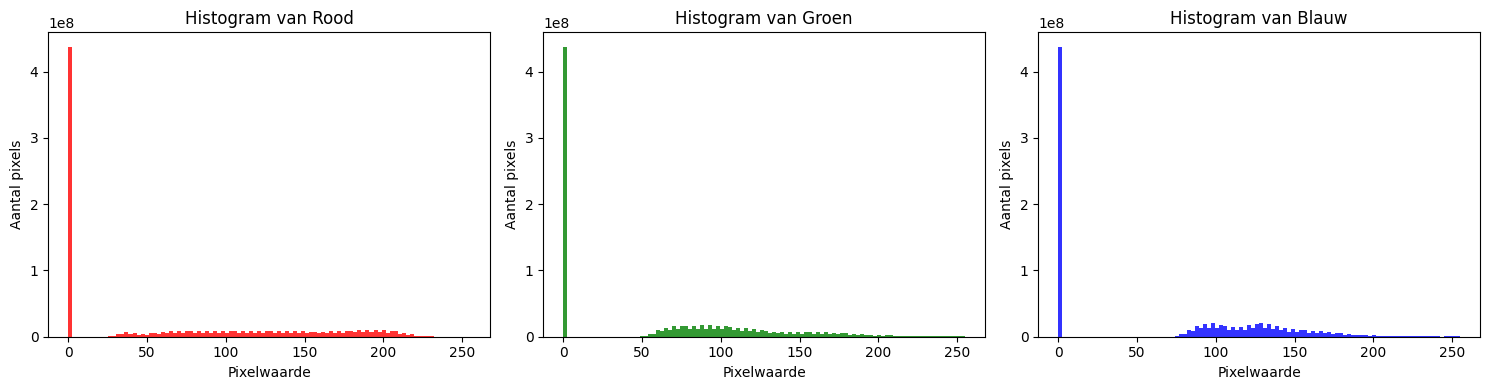

In [3]:
# Open raster en lees RGB-banden
with rasterio.open("../data/private/haarlem_2024_cir.tif") as src:
    rgb = src.read([1, 2, 3])  # RGB-banden

# Instellingen
kleuren = ['red', 'green', 'blue']
namen = ['Rood', 'Groen', 'Blauw']

# Plot per kanaal
plt.figure(figsize=(15, 4))
for i in range(3):
    band = rgb[i]
    plt.subplot(1, 3, i + 1)
    plt.hist(band.flatten(), bins=100, color=kleuren[i], alpha=0.8)
    plt.title(f"Histogram van {namen[i]}")
    plt.xlabel("Pixelwaarde")
    plt.ylabel("Aantal pixels")

plt.tight_layout()
plt.show()

Het valt op dat er in elke band een enorme piek van 0 zit: dit zijn pixels zonder waarde, oftewel NoData-pixels. Deze pixels vertekenen het resultaat. Ik check dit in de volgende cel.

In [4]:
print(src.nodata)

None


"None" geeft aan dat er geen expliciete NoData-pixels zijn ingesteld. Echter betekent dit niet dat het raster geen NoData-pixels bevat: in dit geval worden lege gebieden aangeduid met de waarde 0.  
Ik heb het raster geanalyseerd in QGIS en vastgesteld dat dit inderdaad het geval is. Deze 0-pixels bleken een vierkant te vormen rondom de geclipte luchtfoto van Haarlem.

In [`02_preprocessing.ipynb`](02_preprocessing.ipynb) heb ik een nieuw TIF-bestand aangemaakt waarin alle 0-pixels zijn omgezet naar `NaN`.  
Ik voer de bovenstaande analyse opnieuw uit, maar nu met het 'schone' bestand.

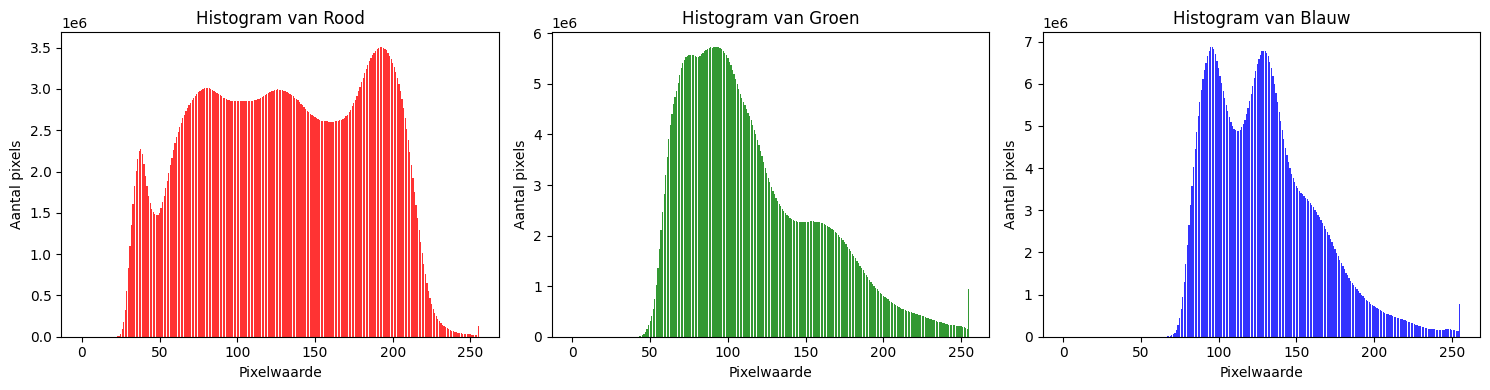

In [5]:
# Bestandspad
path = "../data/private/haarlem_2024_cir_nan.tif"

# Instellingen
kleuren = ['red', 'green', 'blue']
namen = ['Rood', 'Groen', 'Blauw']
histogrammen = [np.zeros(256) for _ in range(3)]  # max 256 bins

# Histogrammen vullen
with rasterio.open(path) as src:
    for ji, window in src.block_windows(1):
        data = src.read([1, 2, 3], window=window)

        # Vervang NaN met maskering
        mask = ~np.isnan(data)
        for i in range(3):
            valid = data[i][mask[i]]
            vals, _ = np.histogram(valid, bins=256, range=(0, 255))
            histogrammen[i] += vals

# Plot
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.bar(np.arange(256), histogrammen[i], color=kleuren[i], alpha=0.8)
    plt.title(f"Histogram van {namen[i]}")
    plt.xlabel("Pixelwaarde")
    plt.ylabel("Aantal pixels")

plt.tight_layout()
plt.show()


Dat ziet er beter uit! Dit zijn logische waarden voor RGB histogrammen. Donkere rode gebieden zijn vaak schaduw, wat of bebossing, de lichtere rode gebieden reflecties van bijvoorbeeld daken of droge grond. De groene pixels zijn, uiteraard, typisch voor vegetatie. Blauwe pixels kunnen indicatief zijn voor vegetatie of stedelijke oppervlakken in schaduw.

Hieronder bekijken we een stukje van de kaart als subset: de Grote Markt.

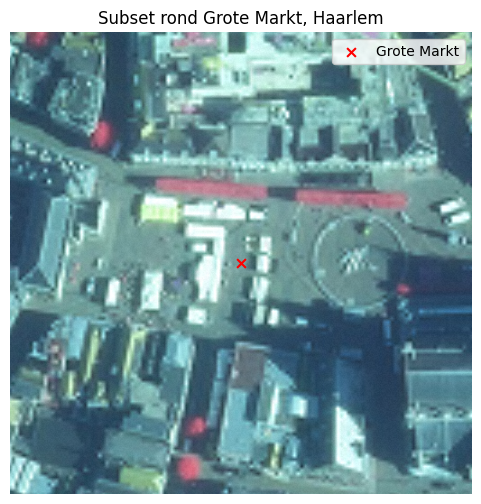

In [6]:
# Coördinaten van de Grote Markt in EPSG:28992 (RD)
x_rd, y_rd = 103837.170, 488436.060

# Pad naar het GeoTIFF-bestand
input_path = "../data/private/haarlem_2024_cir_nan.tif"

# Open rasterbestand en bepaal pixelpositie
with rasterio.open(input_path) as src:
    row, col = src.index(x_rd, y_rd)

    # Definieer venster van 512x512 pixels rondom de locatie
    window = Window(col - 256, row - 256, 512, 512)
    data = src.read([1, 2, 3], window=window)

# Vervang NaN door 0 voor weergave
data = np.where(np.isnan(data), 0, data)

# Herstructureer array naar (rows, cols, bands) voor imshow
rgb = np.moveaxis(data, 0, -1)

# Plot het beeld met marker op de Grote Markt
plt.figure(figsize=(6, 6))
plt.imshow(rgb.astype('uint8'))
plt.scatter(256, 256, c='red', s=40, marker='x', label='Grote Markt')
plt.title("Subset rond Grote Markt, Haarlem")
plt.axis('off')
plt.legend()
plt.show()
